# On using Julia's Optimizer packages 
**Razi Ahmed, Caltech/Jet Propulsion Lab, 2021**

*tested with Julia v1.5.3, IJulia v1.23.2, JuMP v0.21.6, Optim v1.2.4*

## Problem 1: 
Range and look angle for a spherical earth using law of cosines
$$ r^2_e = ρ^2 + (r_e + h_p)^2 - 2 ρ(r_e + h_p)\cosθ_l $$
 
Exercise: find $θ_l$ for a given set of $ρ$, $h_p$ and $r_e$ and above equation

Truth can be obtained by setting ρ such that 
$$ \rho = (r_e + h_p)\cosθ_l - \sqrt{(r_e + h_p)^2 \cos^2θ_l + r^2_e - (r_e + h_p)^2} $$
        

In [4]:
#finding θ using Julias JuMP tool

using JuMP
using Ipopt

#toy spherical geometry problem
re_an = 6378.137e3
hp_an = 809e3
θ_an = 35π/180 # true value
ρ_an = (re_an + hp_an)*cos(θ_an) - sqrt((re_an + hp_an)^2*cos(θ_an)^2 + re_an^2 - (re_an + hp_an)^2) 

#define function to minimize, square instead of abs() saves a lot of time
myfn(ρ, re, hp, θ) = (ρ^2 + (re+hp)^2 - 2*ρ*(re + hp)*cos(θ) - re^2)^2

#set up model
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0) # to shush it a bit

# set up constants and variables 
@variable(model, 34π/180 <=  θ <= 36π/180 ) #find θ
@variable(model, ρ == ρ_an)
@variable(model, re == re_an)
@variable(model, hp == hp_an)

# tell the optimizer about the function 
register(model, :myfn, 4, myfn, autodiff=true)

#define the objective of the optimization
@NLobjective(model, Min, myfn(ρ, re, hp, θ))

# run the optimizer 
optimize!(model);
@time optimize!(model);
@time optimize!(model);


# show values 
println("ρ = ", value(ρ), ", hp = ", value(hp), ", θ = ", value(θ)*180/π, ", re = ", value(re))

println("Analytical: θ_an = ", θ_an*180/π);
println("Estimated:  θ_es = ", value(θ)*180/π);
println("Difference = ", (value(θ) - θ_an)*180/π, " deg")

  0.009467 seconds (413 allocations: 23.344 KiB)
  0.010787 seconds (413 allocations: 23.344 KiB)
ρ = 1.020461916760888e6, hp = 809000.0, θ = 35.00000000000008, re = 6.378137e6
Analytical: θ_an = 35.0
Estimated:  θ_es = 35.00000000000008
Difference = 7.63333123551244e-14 deg


In [5]:
# finding θ using Julia's Optim minimizer

using Optim

#toy spherical geometry problem
re_an = 6378.137e3
hp_an = 809e3
θ_an = 60π/180 # true value
ρ_an = (re_an + hp_an)*cos(θ_an) - sqrt((re_an + hp_an)^2*cos(θ_an)^2 + re_an^2 - (re_an + hp_an)^2) 

#define function to minimize, square doesn't save that much time over abs()
myfn(θ) = (ρ_an^2 + (re_an+hp_an)^2 - 2*ρ_an*(re_an + hp_an)*cos(θ) - re_an^2)^2

@time res = optimize(myfn, θ_an - 5π/180, θ_an + 5π/180);
@time res = optimize(myfn, θ_an - 5π/180, θ_an + 5π/180);

println("Analytical: θ_an = ", θ_an*180/π);
println("Estimated:  θ_es = ", Optim.minimizer(res)*180/π);
println("Difference: θ_err = ", (θ_an - Optim.minimizer(res))*180/π);


  0.215778 seconds (1.26 M allocations: 63.371 MiB)
  0.000107 seconds (684 allocations: 10.828 KiB)
Analytical: θ_an = 59.99999999999999
Estimated:  θ_es = 60.000000066290085
Difference: θ_err = -6.629008755968579e-8


## Problem 2: 
Find $θ_l$ for iso-range lines on an ellipsoid 
$$    ρ = \frac{-r_b - \sqrt{r^2_b -4 r_a r_c}}{2r_a} $$
where 
$$    r_a = \frac{\hat l^2_x + \hat l^2_y}{R^2_a} + \frac{\hat l^2_z}{R^2_a(1 - e^2)} $$
$$    r_b = 2\left(\frac{\hat l_x \cdot \vec P_x + \hat l_y \cdot \vec P_y}{R^2_a} + \frac{\hat l^2_z \cdot \vec P_z}{R^2_a(1 - e^2)}\right) $$
$$    r_c = \frac{\vec P^2_x + \vec P^2_y}{R^2_a} + \frac{\vec P^2_z}{R^2_a(1 - e^2)}- 1 $$

where
$$   \hat l = (\sin\theta \sin\phi) \hat t + (\sin\theta \cos\phi) \hat c + (\cos\theta \hat) n $$ 
    
Exercise: find $θ_l$ for a given set of $\rho$, $\phi_{az}$,  $R_a$, $e$ and above equation



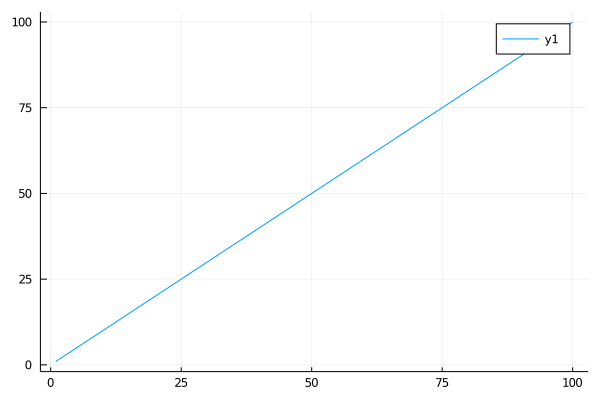

In [5]:
using Plots
include("../modules/geometry.jl")
include("../modules/scene.jl")
